<a href="https://colab.research.google.com/github/alexandre858/DataMinig/blob/main/Projet_implemente.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projet suggestion de pokémon**

Base d'images:
https://www.kaggle.com/datasets/vishalsubbiah/pokemon-images-and-types



---



# **Annotation et classification**

Ce programme permet, depuis un fichier csv et des images, de créer un dossier et un fichier json qui associera à chaque image des données.

Les données sont les suivantes:

      "name": nom de l'image
      "size_high": hauteur de l'image
      "size_lenght": largeur de l'image
      "format": format de l'image
      "red": taux de presence dans l'image du rouge
      "green": taux de presence dans l'image du vert
      "blue": taux de presence dans l'image du bleu
      "col_dom_r": canal rouge de la couleur dominante
      "col_dom_g": canal vert de la couleur dominante
      "col_dom_b": canal bleu de la couleur dominante
      "int_col_dom_r": interval du canal rouge dans le quel se situe la couleur dominante rouge
      "int_col_dom_g": interval du canal vert dans le quel se situe la couleur dominante vert
      "int_col_dom_b": interval du canal bleu dans le quel se situe la couleur dominante bleu
      "Type1": type primaire du pokémon
      "Type2": type secondaire du pokémon

In [48]:
import os,sys
import json
import pathlib
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plot
import numpy
import math
from sklearn.cluster import MiniBatchKMeans

#Création dossier data
try:
   os.mkdir('data')
except:
    pass

donnees = {}
 
path = '.'

files = sorted(os.listdir(path+"/images"))

#Trie et manipulation du fichier csv
#---------------------------------------------------
df = pd.read_csv(path+"/pokemon.csv")
df.shape

#creation d'un tableau trié par ordre alphabètique
df2 = df.sort_values(by=['Name'], ascending=True).reset_index(drop=True)

#Parcours par ordre alphabètique
img_name = sorted(os.listdir(path+'/images'))

#Création d'une liste contenat les adresses des images
img_paths = []

for i in img_name:
    img_paths.append(path+i)

df2['adresses'] = img_paths
#---------------------------------------------------

#Parcours les images du dossier
i=1
for name in files:
  type1 = ""
  type2 = ""

  #Vérification qu'il s'agit bien d'un fichier et non d'un dossier
  if os.path.isfile("images/"+name):
    imgfile = Image.open("images/"+name)


    #Algoritme qui détermine la couleur dominante d'une image 
    #Utilisation de MiniBatchKmeans
    #---------------------------------------------------
    numarray = numpy.array(imgfile.getdata(), numpy.uint8)
    if (len(numarray.shape)==2):

      cluster_count = 5

      clusters = MiniBatchKMeans(n_clusters=cluster_count)
      clusters.fit(numarray)

      npbins = numpy.arange(0, cluster_count+1)
      histogram = numpy.histogram(clusters.labels_, bins=npbins)

      #Récupération de l'index du max de l'histogram 

      #(La première couleur dominate est noir car l'image n'a pas d'arriere plan
      #et les pixels sont donc considérés comme noir par l'algorithme donc on ne la 
      #récupère pas, on concidère que la deuxième)
      index_max = numpy.where(histogram[0]==max(histogram[0]))

      histogram[0][index_max] = 0

      index_max = numpy.where(histogram[0]==max(histogram[0]))

      #Récupération de la valeur de chaque canaux de la couleur dominante
      col_dom_r = math.ceil(clusters.cluster_centers_[index_max[0][0]][0])
      col_dom_g = math.ceil(clusters.cluster_centers_[index_max[0][0]][1])
      col_dom_b = math.ceil(clusters.cluster_centers_[index_max[0][0]][2])

    #Si il s'agit d'une image monochromatique
    else:
      col_dom_r = 500
      col_dom_g = 500
      col_dom_b = 500
    #---------------------------------------------------


    #Découpage et assosiation des couleurs à un interaval de couleur
    #---------------------------------------------------
    list_col=[col_dom_r, col_dom_g, col_dom_b]
    interval_r = 0
    interval_g = 0
    interval_b = 0
    list_int_col = [interval_r, interval_g, interval_b]

    #Découpage en 8 intervals
    inter=[range(0,32), range(32,64), range(64,96), range(96,128), range(128,160), range(160,192), range(192,224), range(224,257)]

    #Determine dans quel interval de chaque canaux la couleur appartient
    for i in range (0,3):
      if (list_col[i] in inter[0]):
        list_int_col[i] = 0

      elif (list_col[i] in inter[1]):
        list_int_col[i] = 1

      elif (list_col[i] in inter[2]):
        list_int_col[i] = 2

      elif (list_col[i] in inter[3]):
        list_int_col[i] = 3

      elif (list_col[i] in inter[4]):
        list_int_col[i] = 4

      elif (list_col[i] in inter[5]):
        list_int_col[i] = 5

      elif (list_col[i] in inter[6]):
        list_int_col[i] = 6

      elif (list_col[i] in inter[7]):
        list_int_col[i] = 7

      else:
        #Si monochromatique
        list_int_col[i] = "NaN"
    #---------------------------------------------------


    #Analyse taux de présence couleurs
    #---------------------------------------------------
    histogram = imgfile.histogram()

    if (len(histogram)==1024 or len(histogram)==768):

      red = histogram[0:255]
      green = histogram[256:511]
      blue = histogram[512:767]

      total_red = 0
      total_blue = 0
      total_green = 0

      j = 0
      #Calcul du taux de présence pour chaque couleur
      #Plus la nuance est élevée plus elle a du poids (coefficient élevé)
      while j <255:
        total_red = total_red+red[j]*j
        total_blue = total_blue+blue[j]*j
        total_green = total_green+green[j]*j
        j += 1

    #Si monochrome
    else:
      total_red = 0
      total_green = 0
      total_blue = 0
    #---------------------------------------------------


    #Récupération des données sur le format de l'image
    #---------------------------------------------------
    hauteur = imgfile.size[0]
    largeur = imgfile.size[1]
    format = imgfile.format
    #---------------------------------------------------


    #mise en place des données dans un fichier json
    #---------------------------------------------------
    dele = 4
    if (imgfile.format=="JPEG"):
      dele = 5

    #Récupération des types
    for index,  row in df2.iterrows():
      if name==row["Name"]+".png":
        type1 = row["Type1"]
        type2 = row["Type2"]

    #Mise en place de toutes les informations dans la variable "donnees"
    donnees[name]={"name":name[:-dele], "size_high":hauteur,
                    "size_lenght":largeur, "format":format,
                      "red":total_red, "green":total_green, "blue":total_blue,
                        "col_dom_r":col_dom_r, "col_dom_g":col_dom_g, "col_dom_b":col_dom_b,
                          "int_col_dom_r":list_int_col[0], "int_col_dom_g":list_int_col[1], "int_col_dom_b":list_int_col[2],
                            "Type1":type1, "Type2":type2}

    i = i + 1 

#Création du fichier json et importation de la variable "donnees" dans le fichier
with open("data/data.json", "w") as file:
    json.dump(donnees, file,indent = 3)
#---------------------------------------------------


# **Visualisation des informations de la base d'image**

Ce programme permet d'abord de visualiser le nombre d'images associés à un format.

Il permet aussi de visualiser la quantité d'images associées à chaque type (primaire et secondaire).

Il permet égualement de visualiser trois histograms qui affichent toutes les nuances des trois des canaux de toutes les couleurs dominantes.

Et finalement, il permet d'afficher trois histograms de taux de présence de chaque canal de chaque images.

           Typ
         count
Type1         
            88
Bug         63
Dark        28
Dragon      24
Electric    36
Fairy       17
Fighting    25
Fire        47
Flying       3
Ghost       23
Grass       66
Ground      30
Ice         23
Normal      93
Poison      28
Psychic     47
Rock        41
Steel       22
Water      105
           Typ
         count
Type2         
            88
Bug          3
Dark        16
Dragon      14
Electric     6
Fairy       18
Fighting    19
Fire         9
Flying      87
Ghost       12
Grass       18
Ground      30
Ice         10
Normal       4
Poison      31
Psychic     27
Rock        14
Steel       19
Water       13
nan        371
        form
       count
format      
JPEG      88
PNG      721


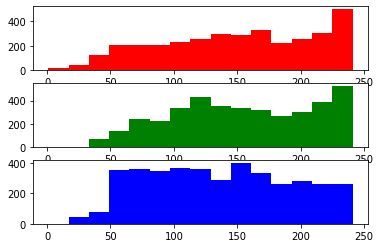

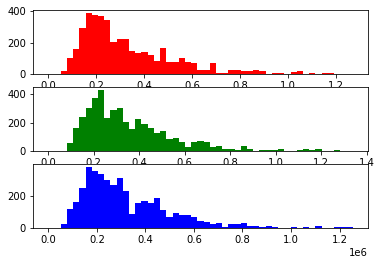

In [49]:
import matplotlib.pyplot as plot
import math
import json
from pandas.io.json import json_normalize
import pandas as pd

#Ouverture du fichier json contenant les données liées à chaque images
jsondata = json.load(open('data/data.json'))
list_col = ["col_dom_r","col_dom_g","col_dom_b","red","green","blue"]

list_dom_r = []
list_dom_g = []
list_dom_b = []

list_r = []
list_g = []
list_b = []

list_list=[list_dom_r, list_dom_g, list_dom_b, list_r, list_g, list_b]

array_type1 = []
array_type2 = []
array_format = []

#Récupération des Types primaires et secondaires de chaques images ainsi que le format
for data in jsondata:
  array_type1.append([jsondata[data]["Type1"], jsondata[data]["Type1"]])
  array_type2.append([jsondata[data]["Type2"], jsondata[data]["Type2"]])
  array_format.append([jsondata[data]["format"], jsondata[data]["format"]])
  
  #Récupération de la couleur dominante 
  #et du taux de présence de couleurs de chaque images
  for i in range (0, 6):
    list_list[i].append(jsondata[data][list_col[i]])

    #Récupération de la couleur dominante 
    #et du taux de présence de couleurs de chaque images
    for i in range (0, 6):
      list_list[i].append(jsondata[data][list_col[i]])

#Création d'un tableau de type pandas regroupant les informations du format
#---------------------------------------------------
dataframe = pd.DataFrame(array_format, columns=["format", "form"]) 

dataframe = dataframe.astype(dtype={"format" : "<U200","form" : "<U200"})

#Regroupement par foramt
Format = dataframe.groupby(["format"]).agg(["count"])
#---------------------------------------------------


#Création d'un tableau de type pandas regroupant les informations de "Type1"
#---------------------------------------------------
dataframe = pd.DataFrame(array_type1, columns=["Type1", "Typ"]) 

dataframe = dataframe.astype(dtype={"Type1" : "<U200","Typ" : "<U200"})

#Regroupement par type secondaire
Type1 = dataframe.groupby(["Type1"]).agg(["count"])
#---------------------------------------------------


#Création d'un tableau de type pandas regroupant les informations de "Type2"
#---------------------------------------------------
dataframe2 = pd.DataFrame(array_type2,columns=["Type2","Typ"]) 

dataframe2 = dataframe2.astype(dtype= {"Type2" : "<U200","Typ" : "<U200"})

#Regroupement par type secondaire
Type2 = dataframe2.groupby(["Type2"]).agg(["count"])
#---------------------------------------------------


#Affichage du regroupement du type primaire et secondaire
#---------------------------------------------------
print(Type1)
print(Type2)
print(Format)

#Affichage histogram des couleurs dominantes
fig, axs = plot.subplots(3)
axs[0].hist(list_list[0],range(1, 256, 16), color='red')
axs[1].hist(list_list[1],range(1, 256, 16), color='green')
axs[2].hist(list_list[2],range(1, 256, 16), color='blue')
plot.show()

#Affichage histogram du taux de présences des canaux 
fig, axes = plot.subplots(3)
axes[0].hist(list_list[3], range(1, max(list_list[3]), math.ceil((max(list_list[3])-min(list_list[3]))/50)), color='red')
axes[1].hist(list_list[4], range(1, max(list_list[4]), math.ceil((max(list_list[4])-min(list_list[4]))/50)), color='green')
axes[2].hist(list_list[5], range(1, max(list_list[5]), math.ceil((max(list_list[5])-min(list_list[5]))/50)), color='blue')
plot.show()

# **Simulation d'un utilisateur**

Ce programme choisis de manière aléatoire des images et affecte à certaines un "1" et pour d'autres un "0" de manière semi-aléatoire ou manuel selon le choix de l'utilisateur.

"1" représente un like et "0" ne représente rien.


In [50]:
from PIL import Image
import matplotlib.pyplot as plot
import matplotlib.image as mpimg
import json
from random import seed,random

#La seed permet d'executer toujours la même séquence aléatoire
seed(2)

#Saisie mode manu ou auto
n = int(input("Entrez 1 pour un choix manuel ou 0 pour auto :"))

manual_choice = False

if (n==1):
  manual_choice=True

  #saisie nombre d'image à proposer
  nb_image_to_like = int(input("Entrez le nombre d'images à proposer :"))

else:
  nb_image_to_like = 10

#Création dossier data
try:
   os.mkdir('data')
except:
    pass

path='.'
files = os.listdir(path+"/images")

#Ouverture du fichier json contenant les données liées à chaque images
jsondata = json.load(open('data/data.json'))

i=0
for name in files:
  #Vérification qu'il s'agit bien d'un fichier et non d'un dossier
  if os.path.isfile("images/"+name):
    #Lorsque la saisie est en cours
    if (i<nb_image_to_like):
      #Si on choisis le mode manu
      if (manual_choice):
        #Affichage de l'image
        img = mpimg.imread("images/"+name)
        imgplot = plot.imshow(img)
        plot.show()

        n = int(input("Entrez 1 si vous aimez, ou 0 si non : "))

        #Ajout de l'attribut avec la valeur associée
        jsondata[name]["liked"] = n

        i = i+1

      #Si on choisis le mode auto
      else:
        #Génération d'un entier aléatoire qui vaut 0 ou 1
        n = round(random())

        #Ajout de l'attribut avec la valeur associée
        jsondata[name]["liked"]=n
        i = i+1

    else:
      #Si la saisie est terminée
      jsondata[name]["liked"] = "NaN"

#Mise en place des données dans une variable puis création d'un fichier json
donnees=jsondata

with open("data/data_liked.json", "w") as file:
    json.dump(donnees, file,indent = 3)


Entrez 1 pour un choix manuel ou 0 pour auto :0


# Visualisation des données de l'utilsateur

Ce programme permet de visualiser les mêmes types de données que le programme de visualisation des données de la base d'images mais cette fois-ci il affiche les données que l'utilsateur a aimé.

           Typ
         count
Type1         
            88
Bug         63
Dark        28
Dragon      24
Electric    36
Fairy       17
Fighting    25
Fire        47
Flying       3
Ghost       23
Grass       66
Ground      30
Ice         23
Normal      93
Poison      28
Psychic     47
Rock        41
Steel       22
Water      105
           Typ
         count
Type2         
            88
Bug          3
Dark        16
Dragon      14
Electric     6
Fairy       18
Fighting    19
Fire         9
Flying      87
Ghost       12
Grass       18
Ground      30
Ice         10
Normal       4
Poison      31
Psychic     27
Rock        14
Steel       19
Water       13
nan        371
        form
       count
format      
JPEG       2
PNG        5


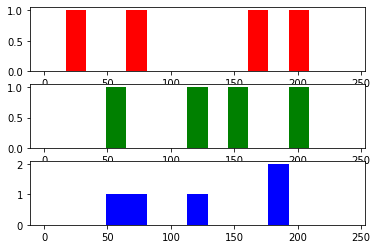

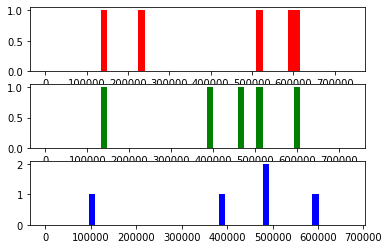

In [51]:
import matplotlib.pyplot as plot
import math
import json
from pandas.io.json import json_normalize
import pandas as pd

#Ouverture du fichier json contenant les données liées à chaque images 
#avec l'information "liked" en plus
jsondata = json.load(open('data/data_liked.json'))
list_col = ["col_dom_r","col_dom_g","col_dom_b","red","green","blue"]

list_dom_r = []
list_dom_g = []
list_dom_b = []

list_r = []
list_g = []
list_b = []

list_list = [list_dom_r, list_dom_g, list_dom_b, list_r, list_g, list_b]

array_tyep2 = []
array_type2 = []
array_format = []
#Récupération des Types primaires et secondaires de chaques images
for data in jsondata:
  #Récupération seulement des images likées par l'utilisateur
  if (jsondata[data]["liked"]==1):
    array_type1.append([jsondata[data]["Type1"], jsondata[data]["Type1"]])
    array_type2.append([jsondata[data]["Type2"], jsondata[data]["Type2"]])
    array_format.append([jsondata[data]["format"], jsondata[data]["format"]])
    #Récupération de la couleur dominantes 
    #et du taux de présence de couleurs de chaque images
    for i in range (0, 6):
      list_list[i].append(jsondata[data][list_col[i]])

#Création d'un tableau de type pandas regroupant les information du format des images
#------------------------------------------------
dataframe = pd.DataFrame(array_format, columns=["format", "form"]) 

dataframe = dataframe.astype(dtype={"format" : "<U200", "form" : "<U200"})

#Regroupement par format
Format = dataframe.groupby(["format"]).agg(["count"])
#------------------------------------------------


#Création d'un tableau de type pandas regroupant les informations de "Type1"
#------------------------------------------------
dataframe = pd.DataFrame(array_type1, columns=["Type1", "Typ"]) 

dataframe = dataframe.astype(dtype={"Type1" : "<U200", "Typ" : "<U200"})

#Regroupement par type secondaire
grouped = dataframe.groupby(["Type1"]).agg(["count"])
#------------------------------------------------


#Création d'un tableau de type pandas regroupant les informations de "Type2"
#------------------------------------------------
dataframe2 = pd.DataFrame(array_type2, columns=["Type2", "Typ"]) 

dataframe2 = dataframe2.astype(dtype={"Type2" : "<U200","Typ" : "<U200"})

#Regroupement par type secondaire
grouped2 = dataframe2.groupby(["Type2"]).agg(["count"])
#------------------------------------------------

#Affichage du regroupement du type primaire et secondaire
print(Type1)
print(Type2)
print(Format)

#Affichage histogram des couleurs dominantes
fig, axs = plot.subplots(3)
axs[0].hist(list_list[0], range(1, 256, 16), color='red')
axs[1].hist(list_list[1], range(1, 256, 16), color='green')
axs[2].hist(list_list[2], range(1, 256, 16), color='blue')
plot.show()

#Affichage histogram du taux de présences des canaux 
fig, axes = plot.subplots(3)
axes[0].hist(list_list[3], range(1, max(list_list[3]), math.ceil((max(list_list[3])-min(list_list[3]))/50)), color='red')
axes[1].hist(list_list[4], range(1, max(list_list[4]), math.ceil((max(list_list[4])-min(list_list[4]))/50)), color='green')
axes[2].hist(list_list[5], range(1, max(list_list[5]), math.ceil((max(list_list[5])-min(list_list[5]))/50)), color='blue')
plot.show()


# **Traitement des images aimées et Classement de la base d'image**

Ce programme permet de définir quel type de suggestion l'utilisateur veut faire à l'aide de balises (par types, par format, par couleur ou automatiquement (tous))

Ce programme traite ensuite les images qui ont été aimées en récupérent:

1.   La moyenne des couleurs dominantes aimées
2.   Les type primaires et secondaires aimés,
3.   Le format qui est aimé.

Il mesure ensuite la pertinance de toutes les autres images à l'aide d'un système de point, plus la variable "point" d'une image est élevée plus l'image correspond à ce que l'utilisateur pourrait potentiellement aimer.





In [52]:
from collections import Counter 
import json

#Liste contenant les balises que l'utilisateur veut utiliser pour la suggestion
list_balise = []

#Tant que l'utilisateur ne rentre pas de balise valable la boucle recommence
while (("format" in list_balise or "type" in list_balise or "couleur" in list_balise or "auto" in list_balise)==False):
  n=input("Par quelle balise voulez vous trier: format, type, couleur (plusieurs choix possible) ou auto :")
  list_balise=n.split(" ")

#Balises
format = False
Type = False
color = False
auto = False

if ("format" in list_balise):
  format = True

if ("type" in list_balise):
  Type = True

if ("couleur" in list_balise):
  color = True

if ("auto" in list_balise):
  auto = True

#Ouverture du fichier json contenant information des images likées
jsondata = json.load(open('data/data_liked.json'))

moy_int_cd_r = 0
moy_int_cd_g = 0
moy_int_cd_b = 0
Nb = 0
list_type = []
Point = 0
list_all_types = []
nb_png = 0
nb_jpeg = 0
mono = 0

#Parcours de chaque images présent dans le json
for data in jsondata:
  #Récupération de la liste de tous les types primaires et secondaires différents possibles
  if (not(jsondata[data]["Type1"])in list_all_types and str(jsondata[data]["Type2"])!="nan" and jsondata[data]["Type2"]!=""):
    list_all_types.append(jsondata[data]["Type1"])

  if (not(jsondata[data]["Type2"]in list_all_types) and str(jsondata[data]["Type2"])!="nan" and jsondata[data]["Type2"]!=""):
    list_all_types.append(jsondata[data]["Type2"])

  #Si l'image est likée
  if (jsondata[data]["liked"]==1):
    #Si l'image est monochromatique
    if (jsondata[data]["int_col_dom_r"]=="NaN"):
      mono += 1

    #Si non on récupère la valeur de la couleur dominante puis on la somme aux autres
    else:
      moy_int_cd_r = moy_int_cd_r + jsondata[data]["int_col_dom_r"]
      moy_int_cd_g = moy_int_cd_g + jsondata[data]["int_col_dom_g"]
      moy_int_cd_b = moy_int_cd_b + jsondata[data]["int_col_dom_b"]

    #Récupération des Type1 et Type2
    if (str(jsondata[data]["Type2"])!="nan" and jsondata[data]["Type2"]!=""):
      list_type.append(jsondata[data]["Type2"])

    if (jsondata[data]["Type1"]!=""):
      list_type.append(jsondata[data]["Type1"])

    #Récupération du nombre d'image étant au format PNG ou JPEG
    if (jsondata[data]["format"]=="PNG"):
      nb_png += 1

    if (jsondata[data]["format"]=="JPEG"):
      nb_jpeg += 1
    Nb+=1

#Calcule poucentage d'image monochromatique
mono=mono/Nb

#Récupération nombre de type parmis les images likées
nb_type_list = len(list_type)

#Calcule poucentage d'image format PNG ou JPEG
nb_png = nb_png/Nb
nb_jpeg = nb_jpeg/Nb

#Création d'un dictionnaire associant un type à un nombre de point
dict_type = Counter(list_type)

#Retire du dictionnaire "list_all_types" tous les éléments déjà présent dans "dict_type"
for i in dict_type:
  list_all_types.remove(i)
  #Calcul des points en pourcentage
  dict_type[i] = dict_type[i]/nb_type_list

#Ajout de tous les element de la list "list_all_types" dans "dict_type" et associe chaque type ajouté à 0
for i in list_all_types:
  dict_type[i] = 0

#Calcul l'interval moyen dans lequel la couleur moyenne appartient
moy_int_cd_r = round(moy_int_cd_r/Nb)
moy_int_cd_g = round(moy_int_cd_g/Nb)
moy_int_cd_b = round(moy_int_cd_b/Nb)

#attribution de point pour chaque image de la base d'images
point=0
for data in jsondata:
  point=0
  #si l'image n'est pas liked
  if (jsondata[data]["liked"]=="NaN"):
    #Traitement effectué que si color ou auto est True
    if (color or auto):
      #Si la couleur est monochromatique on lui donne les point liés à mono
      if(jsondata[data]["int_col_dom_r"]=="NaN"):
        point = mono

      #Si non une comparaison est fait pour savoir à quel point la couleur dominante
      #est proche de la couleur dominate moyenne likée
      else:
        
        if (jsondata[data]["int_col_dom_r"]==moy_int_cd_r):
          point += 1/3

        elif (moy_int_cd_r-1<=jsondata[data]["int_col_dom_r"]<=moy_int_cd_r+1):
          point += 1/6

        if (jsondata[data]["int_col_dom_g"]==moy_int_cd_g):
          point += 1/3

        elif (moy_int_cd_g-1<=jsondata[data]["int_col_dom_g"]<=moy_int_cd_g+1):
          point += 1/6

        if (jsondata[data]["int_col_dom_b"]==moy_int_cd_b):
          point += 1/3

        elif (moy_int_cd_b-1<=jsondata[data]["int_col_dom_b"]<=moy_int_cd_b+1):
          point += 1/6

    #Traitement effectué que si format ou auto est True
    if (format or auto):
      #Attribution du nombre de point selon si l'image est png ou non 
      #(dépend du nombre d'image png et jpeg likées)
      if(jsondata[data]["format"]=="PNG"):
        point += nb_png

      if (jsondata[data]["format"]=="JPEG"):
        point += nb_jpeg

    #Traitement effectué que si Type ou auto est True
    if (Type or auto):
      #Utilisation du dictionaire pour savoir quel nombre de point
      #doit être attribué selon le type
      point += dict_type[jsondata[data]["Type1"]]
      point += dict_type[jsondata[data]["Type2"]]

    #Ajout de l'attribut point à l'image ainsi que ca valeur associée
    jsondata[data]["point"] = point

#Création et mise en place de l'information dans un fichier json "data_point"
donnees=jsondata
with open("data/data_point.json", "w") as file:
    json.dump(donnees, file,indent = 3)

#Stokage des information liées à l'utilisateur dans "data_user"
data={}
data["user"]={"format_png":nb_png, "format_jpeg":nb_jpeg, "Type":dict_type,
                "int_col_dom_moy_r":moy_int_cd_r, "int_col_dom_moy_g":moy_int_cd_g,
                  "int_col_dom_moy_b":moy_int_cd_b}
                  
with open("data/data_user.json", "w") as file:
    json.dump(data, file,indent = 3)


Par quelle balise voulez vous trier: format, type, couleur (plusieurs choix possible) ou auto :auto


# **Système de recommandation des images**

Ce programme permet de Récupérer un nombre d'images determiner par l'utilisateur qui correspondent le plus possible aux images aimées.

On utilise donc l'attribut point de l'image pour déterminer par ordre quel sont les images les plus pertinantes.

Finalement, les images sont afficher.

Entrer le nombre d'images que vous voulez affficher :10


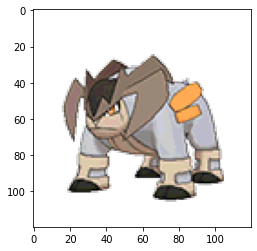

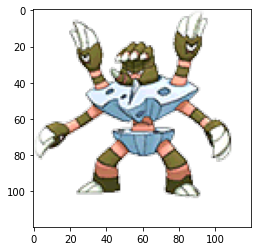

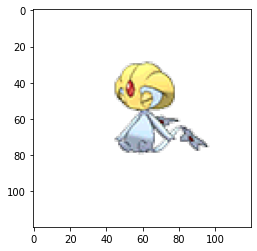

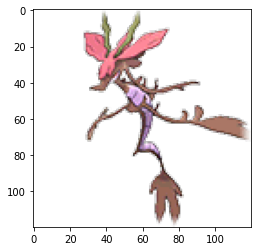

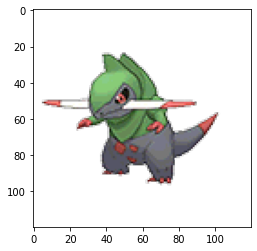

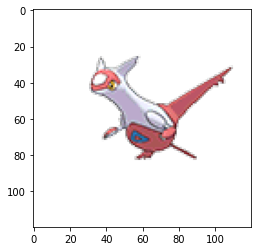

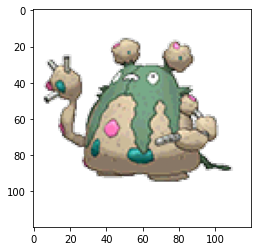

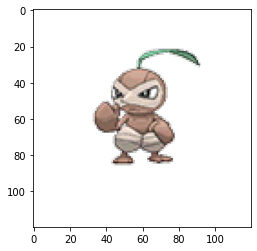

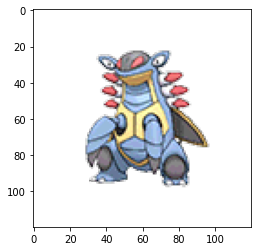

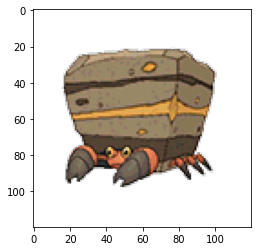

In [54]:
from pandas.io.json import json_normalize
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#Saisie du nombre d'images à afficher
nb_images = int(input("Entrer le nombre d'images que vous voulez affficher :"))

#Ouverture fichier json contenant l'information du nombre de points associés à une image
jsondata = json.load(open('data/data_point.json'))
list_point = []
list_name = []

#Récupération de la liste des points et des noms de chaque image non likées
list_suggestion = []
for data in jsondata:
  if (jsondata[data]["liked"]=="NaN"):
    list_point.append(jsondata[data]["point"])
    list_name.append(data)

list_index_max=[]

#Récupération et affichage des images ayant le nombre de points le plus élevé
for i in range (nb_images):
  index=list_point.index(max(list_point))
  list_suggestion.append(list_name[index])
  #suppression des points de l'image pour pouvoir concidérer les autres ensuite
  list_point[index]=0

  #Affichage des suggestions
  img = mpimg.imread("images/"+list_name[index])
  imgplot = plt.imshow(img)
  plt.show()

#Stokage des informations des images suggérées dans "data_suggestion"
data = {}
for i in list_suggestion:
  data[i] = jsondata[i]

with open("data/data_suggestion.json", "w") as file:
    json.dump(data, file,indent = 3)


# Test et comparaison des résultats

Ce programme permet d'afficher les différentes données qui ont été saisies et analysées.

Il permet notament, d'afficher les informations liées à chaque images aimées, d'afficher les informations moyennes et d'afficher les informations liées aux images suggérée.

In [55]:
import json

#Affichage des données liées à chaque image likées
jsondata = json.load(open('data/data_point.json'))

print("Données des image likées:")
for data in jsondata:
  if (jsondata[data]["liked"]==1):
    print("int_RGB: ", jsondata[data]["int_col_dom_r"],"      ",
            jsondata[data]["int_col_dom_g"], "      ", jsondata[data]["int_col_dom_b"], ", type: ",
              jsondata[data]["Type1"], ", ", jsondata[data]["Type2"], ", format: ",
                jsondata[data]["format"])

#Affichage des données moyennes liées aux images likées
jsondata = json.load(open('data/data_user.json'))

print("")
print("Données moyens des images liked de l'utilisateur:")
print("format png: ",jsondata["user"]["format_png"])
print("format jpeg: ",jsondata["user"]["format_jpeg"])
print("int_RGB: ",jsondata["user"]["int_col_dom_moy_r"]," ",
        jsondata["user"]["int_col_dom_moy_g"]," ",jsondata["user"]["int_col_dom_moy_b"])
print("type: ",jsondata["user"]["Type"])
print("")
print("Données des images suggérées")

#Affichages des informations liées à chaque images suggérées
jsondata = json.load(open('data/data_suggestion.json'))

for data in jsondata:
    print("Point: ", jsondata[data]["point"], ", ", "int_RGB: ", jsondata[data]["int_col_dom_r"], "      ",
            jsondata[data]["int_col_dom_g"], "      ", jsondata[data]["int_col_dom_b"], ", type: ",
              jsondata[data]["Type1"], ", ", jsondata[data]["Type2"], ", format: ",
                jsondata[data]["format"])
    


Données des image likées:
int_RGB:  7        7        2 , type:  Psychic ,  nan , format:  PNG
int_RGB:  7        7        7 , type:   ,   , format:  JPEG
int_RGB:  NaN        NaN        NaN , type:  Normal ,  nan , format:  PNG
int_RGB:  0        4        5 , type:  Steel ,  Fighting , format:  PNG
int_RGB:  2        2        1 , type:  Ghost ,  Dragon , format:  PNG
int_RGB:  6        6        5 , type:   ,   , format:  JPEG
int_RGB:  5        3        3 , type:  Rock ,  Dragon , format:  PNG

Données moyens des images liked de l'utilisateur:
format png:  0.7142857142857143
format jpeg:  0.2857142857142857
int_RGB:  4   4   3
type:  {'Psychic': 0.125, 'Normal': 0.125, 'Fighting': 0.125, 'Steel': 0.125, 'Dragon': 0.25, 'Ghost': 0.125, 'Rock': 0.125, 'Grass': 0, 'Ice': 0, 'Flying': 0, 'Poison': 0, 'Bug': 0, 'Water': 0, 'Fairy': 0, 'Ground': 0, 'Dark': 0, 'Fire': 0, 'Electric': 0}

Données des images suggérées
Point:  1.9642857142857144 ,  int_RGB:  4        4        3 , type:  Rock ,  